In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data
import datetime as dt
from datetime import datetime


# Get Data 

Data is comprised of the SVIX index returns as the response variable, and a set of variables generated from my own production trading strategy that I run in R.

In [3]:
# get SHORTVOL data from my dropbox. Thanks for letting me know, Stuart ^_^

svix = pd.read_csv("https://www.dropbox.com/s/u8qiz7rh3rl7klw/SHORTVOL_Data.csv?raw=1", parse_dates = True, index_col = 0)
svix.head()
svix_rets = svix[' close'].pct_change().dropna()
svix_rets = svix_rets['2008-01-07':]
svix_rets.head()

time
2008-01-07    0.016065
2008-01-08   -0.021563
2008-01-09   -0.003712
2008-01-10    0.037611
2008-01-11   -0.043490
Name:  close, dtype: float64

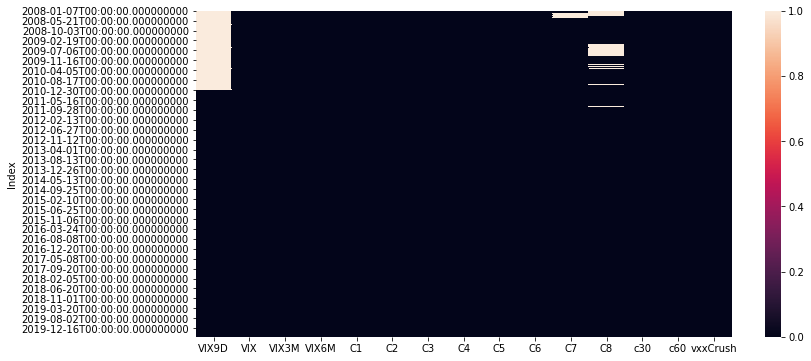

,VIX9D,VIX,VIX3M,VIX6M,C1,C2,C3,C4,C5,C6,C7,C8,c30,c60,vxxCrush
Index,,,,,,,,,,,,,,,
2018-12-04,25.10,20.74,20.75,20.60,19.425,19.275,19.125,19.175,18.975,18.975,18.975,19.100,19.361842,19.353947,-0.328135
2018-12-05,25.10,20.74,20.75,20.60,19.025,19.050,18.975,19.025,18.900,18.900,18.925,19.100,19.036842,19.085526,-0.328135
2018-12-06,25.11,21.19,21.06,20.83,19.925,19.475,19.225,19.275,19.075,19.025,19.025,19.225,19.688158,19.580263,-0.352122


In [4]:
# Get variables from my dropbox. These things are calculated in R because I have my workflow set up in R already. 
# Will have to learn how to dynamically update the dropbox

variables = pd.read_csv("https://www.dropbox.com/s/ykimtkrwpxp80o9/rawVariables.csv?raw=1", parse_dates=True, index_col=0)
variables.head()
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(variables.isnull())
plt.show()
variables['2018-12-04':'2018-12-06']
variables.loc['2018-12-05',['VIX9D', 'VIX', 'VIX3M', 'VIX6M', 'vxxCrush']] = variables.loc['2018-12-04',['VIX9D', 'VIX', 'VIX3M', 'VIX6M', 'vxxCrush']]
variables['2018-12-04':'2018-12-06']


# Preliminary Feature Engineering

Compute various contango ratios, such as front futures contract to the VIX, or various ratios between different cash VIX timeframes.

Visualize some features as well.

In [5]:
# Do some feature engineering -- roll yields and crossover ratios 
# like the one found in my strategy -- called stratcross here

variables['m1_roll_yield'] = variables['C1']/variables['VIX']-1
variables['VX30_roll_yield'] = variables['c30']/variables['VIX']-1
variables['contango'] = variables['C2']/variables['C1']-1
variables['adj_contango'] = variables['c60']/variables['c30']-1
variables['m4m7_contango'] = variables['C7']/variables['C4']-1
variables['fastcross'] = variables['VIX9D']/variables['VIX']
variables['medcross'] = variables['VIX']/variables['VIX3M']
variables['slowcross'] = variables['VIX']/variables['VIX6M']
variables['stratcross'] = variables['VIX3M']/variables['VIX6M']

variables.head()

,VIX9D,VIX,VIX3M,VIX6M,C1,C2,C3,C4,C5,C6,...,vxxCrush,m1_roll_yield,VX30_roll_yield,contango,adj_contango,m4m7_contango,fastcross,medcross,slowcross,stratcross
Index,,,,,,,,,,,,,,,,,,,,,
2008-01-07,NaN,23.79,23.22,24.22,24.12,24.81,24.54,24.45,24.37,24.28,...,0.171019,0.013871,0.031596,0.028607,0.017657,-0.013088,NaN,1.024548,0.982246,0.958712
2008-01-08,NaN,25.43,25.49,25.18,25.54,25.90,25.52,25.35,25.17,25.07,...,0.074774,0.004326,0.013763,0.014096,0.012844,-0.019329,NaN,0.997646,1.009929,1.012311
2008-01-09,NaN,24.12,24.50,24.48,24.89,25.78,25.28,24.76,24.66,24.49,...,0.318373,0.031924,0.058573,0.035757,0.019474,-0.014943,NaN,0.984490,0.985294,1.000817
2008-01-10,NaN,23.45,23.95,24.57,24.07,24.95,24.51,24.36,24.27,24.15,...,0.301873,0.026439,0.055627,0.036560,0.015800,-0.019704,NaN,0.979123,0.954416,0.974766
2008-01-11,NaN,23.68,24.50,24.96,24.96,26.15,26.05,25.92,25.50,25.50,...,0.522062,0.054054,0.095932,0.047676,0.009141,-0.025849,NaN,0.966531,0.948718,0.981571


time
2008-01-07    1
2008-01-08   -1
2008-01-09   -1
2008-01-10    1
2008-01-11   -1
Name:  close, dtype: int64

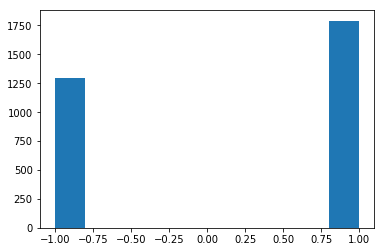

In [6]:
# get the sign of returns

def sign_func(x):
  if x < 0:
    return -1
  if x > 0:
    return 1
  if x == 0:
    return 0

return_sign = svix_rets.apply(sign_func)
plt.hist(return_sign)
return_sign.head()

In [7]:
# regression predicted variable -- that is, we predict the value of 2020-01-23
# with the values we see on 2020-01-21
reg_response = svix_rets.shift(-2, axis = 0)

# classification predicted variable -- we'll be using this one
clf_response = return_sign.shift(-2, axis = 0)

reg_response.tail()

# We'll add these later

time
2020-04-08    0.018589
2020-04-09    0.084119
2020-04-13   -0.083604
2020-04-14         NaN
2020-04-15         NaN
Name:  close, dtype: float64

C:\Users\Ilya\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Ilya\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


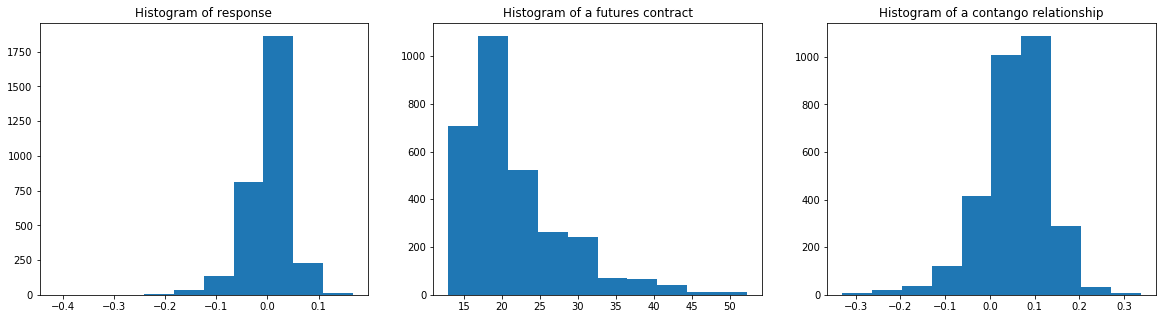

In [58]:
# variables generally are not normal -- the response variable, a contract
# and an example of a contango relationship -- a ratio between two contracts
# log transforms don't really work here due to negative values above -1
# negative values mean boxcox transforms also don't work

plt.figure(figsize = (20, 5))
plt.subplot(1, 3, 1)
plt.hist(reg_response)
plt.title('Histogram of response')
plt.subplot(1, 3, 2)

plt.hist(variables['C4'])
plt.title('Histogram of a futures contract')
plt.subplot(1, 3, 3)
plt.hist(variables['contango'])
plt.title('Histogram of a contango relationship')
plt.show()
#variables = variables.ffill(axis=1)

# Impute Missing Variables

Impute VIX9D by finding the best supervised learning linear model to predict it as a function of highly associated VIX, VIX3M, and VIX6M indices.

Impute various contracts through various existing contract ratios at the time.

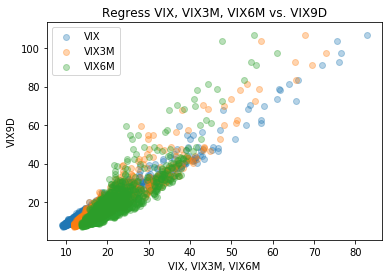

In [9]:
# impute NAs for VIX9D using basic linear regression
# plot relationships between fast and med/slow crosses
plt.scatter(x = variables['VIX'], y = variables['VIX9D'], alpha = .33)
plt.scatter(x = variables['VIX3M'], y = variables['VIX9D'], alpha = .33)
plt.scatter(x = variables['VIX6M'], y = variables['VIX9D'], alpha = .33)
plt.title('Regress VIX, VIX3M, VIX6M vs. VIX9D')
plt.xlabel('VIX, VIX3M, VIX6M')
plt.ylabel('VIX9D')
plt.legend(['VIX', 'VIX3M', 'VIX6M'])

import statsmodels as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

tmp = variables.loc[:,['VIX9D', 'VIX', 'VIX3M', 'VIX6M']]
tmp.head()
X_train = tmp.loc[:,['VIX9D', 'VIX', 'VIX3M', 'VIX6M']].dropna()
y_train = tmp.loc[:,'VIX9D'].dropna()
X_test = tmp.loc[tmp.VIX9D.isnull(),['VIX', 'VIX3M', 'VIX6M']]

del X_train['VIX9D']
# as we can see, there is high correlation between VIX9D vs. VIX/VIX3M/VIX6M. 
# We can run a linear regression model to impute these NA values.

In [10]:
X_train.head()
#y_train.head()
X_test

,VIX,VIX3M,VIX6M
Index,,,
2008-01-07,23.79,23.22,24.22
2008-01-08,25.43,25.49,25.18
2008-01-09,24.12,24.50,24.48
2008-01-10,23.45,23.95,24.57
2008-01-11,23.68,24.50,24.96
2008-01-14,22.90,23.67,24.41
2008-01-15,23.34,24.39,24.90
2008-01-16,24.38,24.36,24.64
2008-01-17,28.46,26.44,26.52


In [11]:
# see which linear regression model gives us best training CV error to impute
# NAs with

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter = 10000)
lasso_cv.fit(X_train, y_train)
print("Best alpha value is: {}".format(lasso_cv.alpha_))
def print_train_stats(X_train, y_train, model):
  model.fit(X_train, y_train)
  y_preds_train = model.predict(X_train)

  print("R-squared of the model in training set is: {}".format(model.score(X_train, y_train)))
  print("Mean absolute error of the prediction in training is: {}".format(mean_absolute_error(y_train, y_preds_train)))
  print("Mean squared error of the prediction in training is: {}".format(mse(y_train, y_preds_train)))
  print("Root mean squared error of the prediction in training is: {}".format(rmse(y_train, y_preds_train)))
  print("Mean absolute percentage error of the prediction in training is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))
print_train_stats(X_train, y_train, lasso_cv)

Best alpha value is: 0.1
R-squared of the model in training set is: 0.9755474397655497
Mean absolute error of the prediction in training is: 0.9520154904096476
Mean squared error of the prediction in training is: 1.8996961258222649
Root mean squared error of the prediction in training is: 1.3782946440519404
Mean absolute percentage error of the prediction in training is: 5.827633825132427


In [12]:
# ridge regression

ridge_cv = RidgeCV(alphas = alphas, cv = 5)
ridge_cv.fit(X_train, y_train)
print("Best alpha value is: {}".format(ridge_cv.alpha_))
print_train_stats(X_train, y_train, ridge_cv)

C:\Users\Ilya\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best alpha value is: 10.0
R-squared of the model in training set is: 0.9760412811931203
Mean absolute error of the prediction in training is: 0.9413605588594443
Mean squared error of the prediction in training is: 1.8613300554504337
Root mean squared error of the prediction in training is: 1.3643057045436824
Mean absolute percentage error of the prediction in training is: 5.7942965963364035


C:\Users\Ilya\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
elastic_cv = ElasticNetCV(alphas = alphas, cv = 5, max_iter = 10000)
elastic_cv.fit(X_train, y_train)

print("Best alpha value is: {}".format(elastic_cv.alpha_))
print_train_stats(X_train, y_train, elastic_cv)

Best alpha value is: 0.1
R-squared of the model in training set is: 0.9756521695818954
Mean absolute error of the prediction in training is: 0.949023742620797
Mean squared error of the prediction in training is: 1.891559766092952
Root mean squared error of the prediction in training is: 1.3753398729379411
Mean absolute percentage error of the prediction in training is: 5.8114913702059745


In [14]:
# use ridge 

variables.VIX9D[0:754] = ridge_cv.predict(X_test)
variables['fastcross'] = variables['VIX9D']/variables['VIX']
# impute missing C7s with C6 multiplied by C6/C5 contango

variables['C7'][variables.C7.isnull()] = variables['C6'][variables.C7.isnull()] * variables['C6'][variables.C7.isnull()]/ variables['C5'][variables.C7.isnull()]

# repeat for C8
variables['C8'][variables.C8.isnull()] = variables['C7'][variables.C8.isnull()] * variables['C7'][variables.C8.isnull()]/ variables['C6'][variables.C8.isnull()]
variables['m4m7_contango'] = variables['C7']/variables['C4']

variables.shape

(3091, 24)

In [15]:
variables.head()
# imputation successful!

,VIX9D,VIX,VIX3M,VIX6M,C1,C2,C3,C4,C5,C6,...,vxxCrush,m1_roll_yield,VX30_roll_yield,contango,adj_contango,m4m7_contango,fastcross,medcross,slowcross,stratcross
Index,,,,,,,,,,,,,,,,,,,,,
2008-01-07,25.568608,23.79,23.22,24.22,24.12,24.81,24.54,24.45,24.37,24.28,...,0.171019,0.013871,0.031596,0.028607,0.017657,0.986912,1.074763,1.024548,0.982246,0.958712
2008-01-08,27.147455,25.43,25.49,25.18,25.54,25.90,25.52,25.35,25.17,25.07,...,0.074774,0.004326,0.013763,0.014096,0.012844,0.980671,1.067537,0.997646,1.009929,1.012311
2008-01-09,25.461086,24.12,24.50,24.48,24.89,25.78,25.28,24.76,24.66,24.49,...,0.318373,0.031924,0.058573,0.035757,0.019474,0.985057,1.055601,0.984490,0.985294,1.000817
2008-01-10,24.516530,23.45,23.95,24.57,24.07,24.95,24.51,24.36,24.27,24.15,...,0.301873,0.026439,0.055627,0.036560,0.015800,0.980296,1.045481,0.979123,0.954416,0.974766
2008-01-11,24.563498,23.68,24.50,24.96,24.96,26.15,26.05,25.92,25.50,25.50,...,0.522062,0.054054,0.095932,0.047676,0.009141,0.974151,1.037310,0.966531,0.948718,0.981571


# More Feature Engineering And Visualization

Create ratios of cash VIX quantities, along with moving averages on those quantities, with lookback time depending on the ratio.

Also, visualize a correlation matrix of the relationships between variables and the response.



In [16]:
# endpoints function for rolling predictions
 
def endpoints(df, on = "M", offset = 0):
    """
    Returns index of endpoints of a time series analogous to R's endpoints
    function. 
    Takes in: 
        df -- a dataframe/series with a date index
          
        on -- a string specifying frequency of endpoints
          
        (E.G. "M" for months, "Q" for quarters, and so on)
          
        offset -- to offset by a specified index on the original data
        (E.G. if the data is daily resolution, offset of 1 offsets by a day)
        This is to allow for timing luck analysis. Thank Corey Hoffstein.
    """
      
    # to allow for familiarity with R
    # "months" becomes "M" for resampling
    if len(on) > 3:
        on = on[0].capitalize()
      
    # get index dates of formal endpoints
    ep_dates = pd.Series(df.index, index = df.index).resample(on).max()
      
    # get the integer indices of dates that are the endpoints
    date_idx = np.where(df.index.isin(ep_dates))
      
    # append zero and last day to match R's endpoints function
    # remember, Python is indexed at 0, not 1
    date_idx = np.insert(date_idx, 0, 0)
    date_idx = np.append(date_idx, df.shape[0]-1)
    if offset != 0:
        date_idx = date_idx + offset
        date_idx[date_idx < 0] = 0
        date_idx[date_idx > df.shape[0]-1] = df.shape[0]-1
    out = np.unique(date_idx)
    return out   
 

In [17]:
# a bit of feature engineering in the variables
variables['fast_diff'] = variables['fastcross'] / variables['fastcross'].rolling(9).mean() -1
variables['med_diff'] = variables['medcross'] / variables['medcross'].rolling(21).mean() -1

# this last one is a feature in my own trading strategy -- I need the ratio to be below its 60 day
# simple moving average
variables['slow_diff'] = variables['slowcross'] / variables['slowcross'].rolling(60).mean() -1
variables['strat_diff'] = variables['stratcross']/variables['stratcross'].rolling(60).mean() - 1

In [18]:
variables['response'] = reg_response
variables.tail()
variables.corr()['response']
variables['clf_response'] = clf_response

In [19]:
variables.head(70)

,VIX9D,VIX,VIX3M,VIX6M,C1,C2,C3,C4,C5,C6,...,fastcross,medcross,slowcross,stratcross,fast_diff,med_diff,slow_diff,strat_diff,response,clf_response
Index,,,,,,,,,,,,,,,,,,,,,
2008-01-07,25.568608,23.79,23.22,24.22,24.12,24.81,24.54,24.45,24.37,24.28,...,1.074763,1.024548,0.982246,0.958712,NaN,NaN,NaN,NaN,-0.003712,-1.0
2008-01-08,27.147455,25.43,25.49,25.18,25.54,25.90,25.52,25.35,25.17,25.07,...,1.067537,0.997646,1.009929,1.012311,NaN,NaN,NaN,NaN,0.037611,1.0
2008-01-09,25.461086,24.12,24.50,24.48,24.89,25.78,25.28,24.76,24.66,24.49,...,1.055601,0.984490,0.985294,1.000817,NaN,NaN,NaN,NaN,-0.043490,-1.0
2008-01-10,24.516530,23.45,23.95,24.57,24.07,24.95,24.51,24.36,24.27,24.15,...,1.045481,0.979123,0.954416,0.974766,NaN,NaN,NaN,NaN,0.032871,1.0
2008-01-11,24.563498,23.68,24.50,24.96,24.96,26.15,26.05,25.92,25.50,25.50,...,1.037310,0.966531,0.948718,0.981571,NaN,NaN,NaN,NaN,-0.009857,-1.0
2008-01-14,23.709978,22.90,23.67,24.41,23.36,25.10,25.07,25.07,24.89,24.90,...,1.035370,0.967469,0.938140,0.969685,NaN,NaN,NaN,NaN,0.007134,1.0
2008-01-15,24.024486,23.34,24.39,24.90,24.04,25.24,25.03,25.10,24.91,24.50,...,1.029327,0.956950,0.937349,0.979518,NaN,NaN,NaN,NaN,-0.070909,-1.0
2008-01-16,25.958379,24.38,24.36,24.64,24.18,24.99,25.03,25.10,24.94,24.50,...,1.064741,1.000821,0.989448,0.988636,NaN,NaN,NaN,NaN,-0.010956,-1.0
2008-01-17,31.779506,28.46,26.44,26.52,26.97,26.62,26.73,26.36,26.25,26.20,...,1.116638,1.076399,1.073152,0.996983,0.054895,NaN,NaN,NaN,-0.011551,-1.0


In [20]:
variables = variables.dropna() # no real way to impute moving averages before the burn-in window, drop NAs
variables.head()

variables.corr()
variables.shape


(3027, 30)

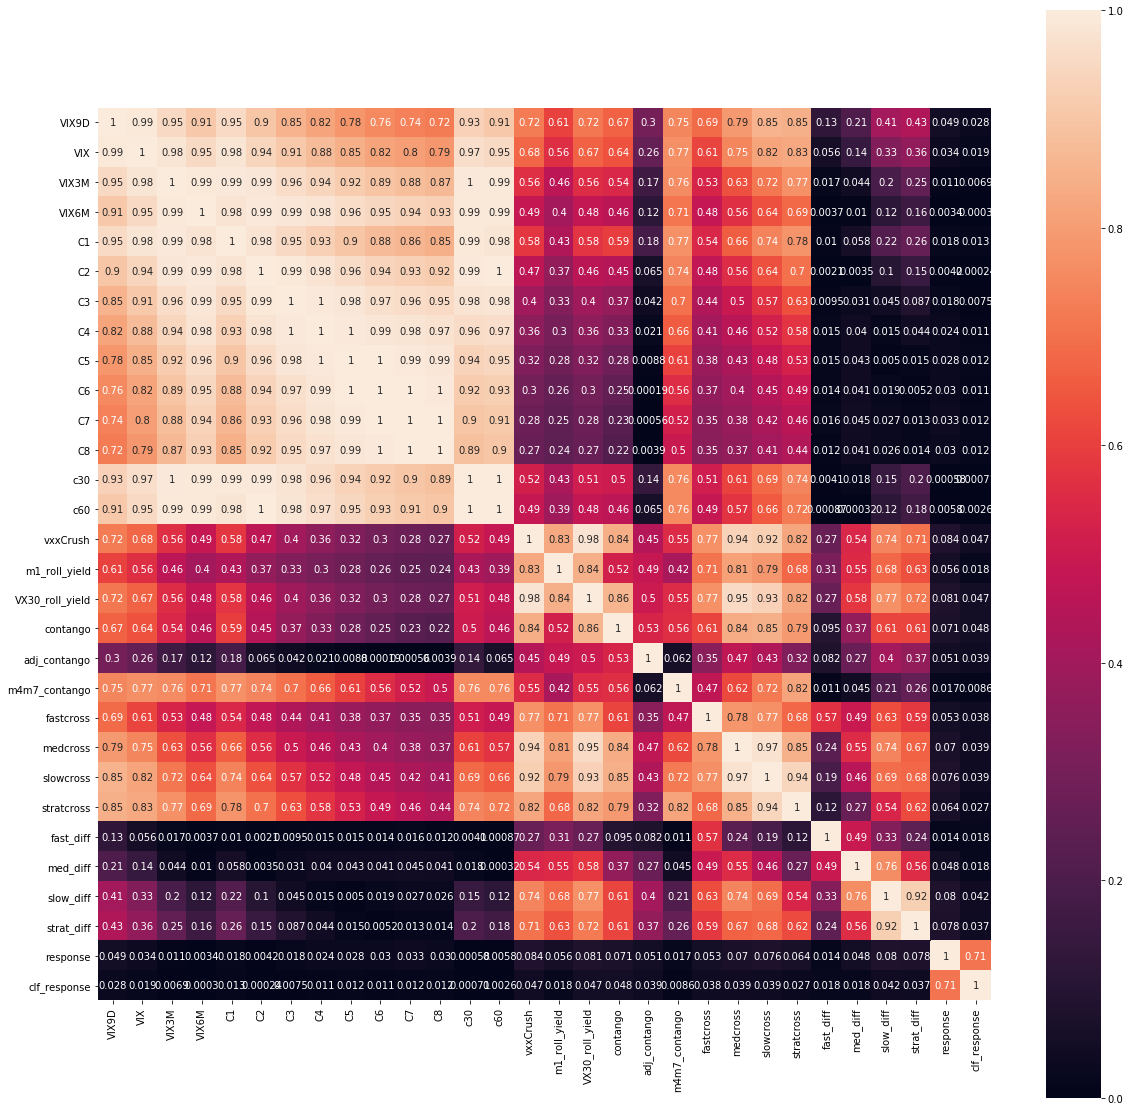

In [21]:
plt.figure(figsize=(20, 20))
sns.heatmap(np.abs(variables.corr()), square = True, annot = True)

# A clearer picture just using absolute values of the correlation matrix
# After all, we don't really care about whether there's a strong positive or negative correlation
# Between variables--we just care about its magnitude.
# Notice that the response variables are pitch black.

# Rolling PCA feature engineering

Use PCAs to engineer features from term stucture, cash vix, contango, cash vix ratios, and moving average of cash vix ratios.
Use an expanding window from which to build PCAs, expanding one month at a time.
Use initial 11 months of data as test set for the rest of the initially out of sample data to get a fully out-of-sample feature generation, then visualize correlation matrix of the result.

In [22]:
# Just do our test work with the first 11 months (the financial crisis)
# As training data, and then one more month as testing data 
# Before putting all of this into a loop

ep = endpoints(variables)

# function to create PCs from various chunks of the variables
from sklearn.decomposition import PCA
def pc_xform(train, test, n_pcs, stem = "PC"):
  pcs = PCA(n_components = n_pcs)
  pcs.fit(train)
  train_xform = pd.DataFrame(pcs.transform(train))
  test_xform = pd.DataFrame(pcs.transform(test))
  train_xform.columns = test_xform.columns = [stem + "_" + str(x) for x in np.array(range(1, n_pcs + 1))]
  train_xform = train_xform.set_index(train.index)
  test_xform = test_xform.set_index(test.index)
  return [train_xform, test_xform]

In [23]:
# THE BIG LONG LOOP

all_pcs = []
for i in range(0, (len(ep)-11)):
#for i in range(0, 10):
 print(i)

 # variables use a rolling window
 # but the machine learning models use an EXPANDING window
 # Why? Because as human beings, we look at the msot data we can.
 # So should a machine learning model, when all features 
 # Become point in time (that is, what was the value of the features at a date?)
 

 # SPLIT TRAINING AND TESTING DATA HERE. TRAINING USES AN EXPANDING WINDOW
 # TESTING DATA IS ALWAYS THE NEXT MONTH AHEAD. THAT IS, MAINTAIN MODEL FOR ONE MONTH.
 # ONE EXCEPTION -- ONCE WE REACH THE END OF THE SIMULATION,
 # OUR INITIAL TRAINING DATA BECOMES THE TEST SET AND ALL THE ROLLING PERIODS BECOME TRAINING DATA.
 # THIS IS SO WE CAN GET AN "OUT OF SAMPLE" TEST ON THE INITIAL BURN-IN DATA
 if(i < len(ep)-12):
   training = variables.iloc[0:ep[i+11]]   
   testing = variables.iloc[(ep[i+11]+1):ep[i+12]]
 else:
   training = variables.iloc[(ep[11]+1):ep[len(ep)-1]]
   testing = variables.iloc[0:ep[11]]
 
 X_train = training.drop(['response', 'clf_response'], axis = 1)
 y_train = training['clf_response']

 X_test = testing.drop(['response', 'clf_response'], axis = 1)
 y_test = testing['clf_response']

 # THIS IS THE SECTION FOR PCAs AND FEATURE ENGINEERING

 # Term structure PCA
 ts_pcs = pc_xform(X_train[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']],
                  X_test[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']],
                  n_pcs = 3,
                  stem = "TS")
 
 # Contango metrics PCA
 contango_pcs = pc_xform(X_train[['vxxCrush', 'm1_roll_yield', 'VX30_roll_yield', 'contango', 'adj_contango', 'm4m7_contango']],
                        X_test[['vxxCrush', 'm1_roll_yield', 'VX30_roll_yield', 'contango', 'adj_contango', 'm4m7_contango']],
                        n_pcs = 3,
                        stem = "Cont")
 
 # Cash VIX PCA (correlated with contango)
 cash_vix_pcs = pc_xform(X_train[['VIX9D',	'VIX',	'VIX3M',	'VIX6M']],
                        X_test[['VIX9D',	'VIX',	'VIX3M',	'VIX6M']],
                        n_pcs = 3,
                        stem = "Cash_Vix")
 
 # Crossover/ratio PCAs (VIX/VIX3M, etc.)
 xover_pcs = pc_xform(X_train[['fastcross', 'medcross', 'slowcross', 'stratcross']],
                     X_test[['fastcross', 'medcross', 'slowcross', 'stratcross']],
                     n_pcs = 3,
                     stem = "Xover")

 # Difference to a moving average PCAs
 maDiff_pcs = pc_xform(X_train[['fast_diff', 'med_diff', 'slow_diff', 'strat_diff']],
                     X_test[['fast_diff', 'med_diff', 'slow_diff', 'strat_diff']],
                     n_pcs = 3,
                     stem = "maDiff")

 # create data frame of new features
 train_pcs = pd.concat([ts_pcs[0], contango_pcs[0], cash_vix_pcs[0], xover_pcs[0], maDiff_pcs[0]], axis = 1)
 test_pcs = pd.concat([ts_pcs[1], contango_pcs[1], cash_vix_pcs[1], xover_pcs[1], maDiff_pcs[1]], axis = 1)
 #test_pcs = test_pcs.dropna()
    
 
 all_pcs.append(test_pcs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


In [24]:
all_pcs_xts = pd.concat(all_pcs, axis=0)
all_pcs_xts
all_pcs_xts = all_pcs_xts.sort_index()
all_pcs_xts.head()

,TS_1,TS_2,TS_3,Cont_1,Cont_2,Cont_3,Cash_Vix_1,Cash_Vix_2,Cash_Vix_3,Xover_1,Xover_2,Xover_3,maDiff_1,maDiff_2,maDiff_3
Index,,,,,,,,,,,,,,,
2008-04-02,11.045711,2.309690,0.473205,0.078545,0.052476,0.040834,9.971500,0.488883,-0.169040,0.161102,0.002650,-0.015355,-0.082186,-0.002639,-0.010357
2008-04-03,10.817431,2.055930,0.597037,0.071053,0.042900,0.050352,9.584914,0.364490,-0.118917,0.151213,0.000371,-0.011007,-0.090813,-0.005079,-0.006894
2008-04-04,10.401045,2.226739,1.109999,-0.096247,0.066709,0.099875,8.126699,0.334903,-0.145608,0.138147,0.000904,-0.013962,-0.100421,-0.003951,-0.009963
2008-04-07,9.313967,1.307193,0.760970,0.065294,0.007982,0.049667,7.944164,0.815594,-0.135912,0.157584,-0.000581,-0.008915,-0.080553,-0.012723,-0.003689
2008-04-08,9.214428,1.151482,0.480510,0.065289,0.013759,0.041367,7.818768,0.866485,-0.097942,0.157731,-0.002537,-0.004274,-0.079784,-0.017001,0.001334


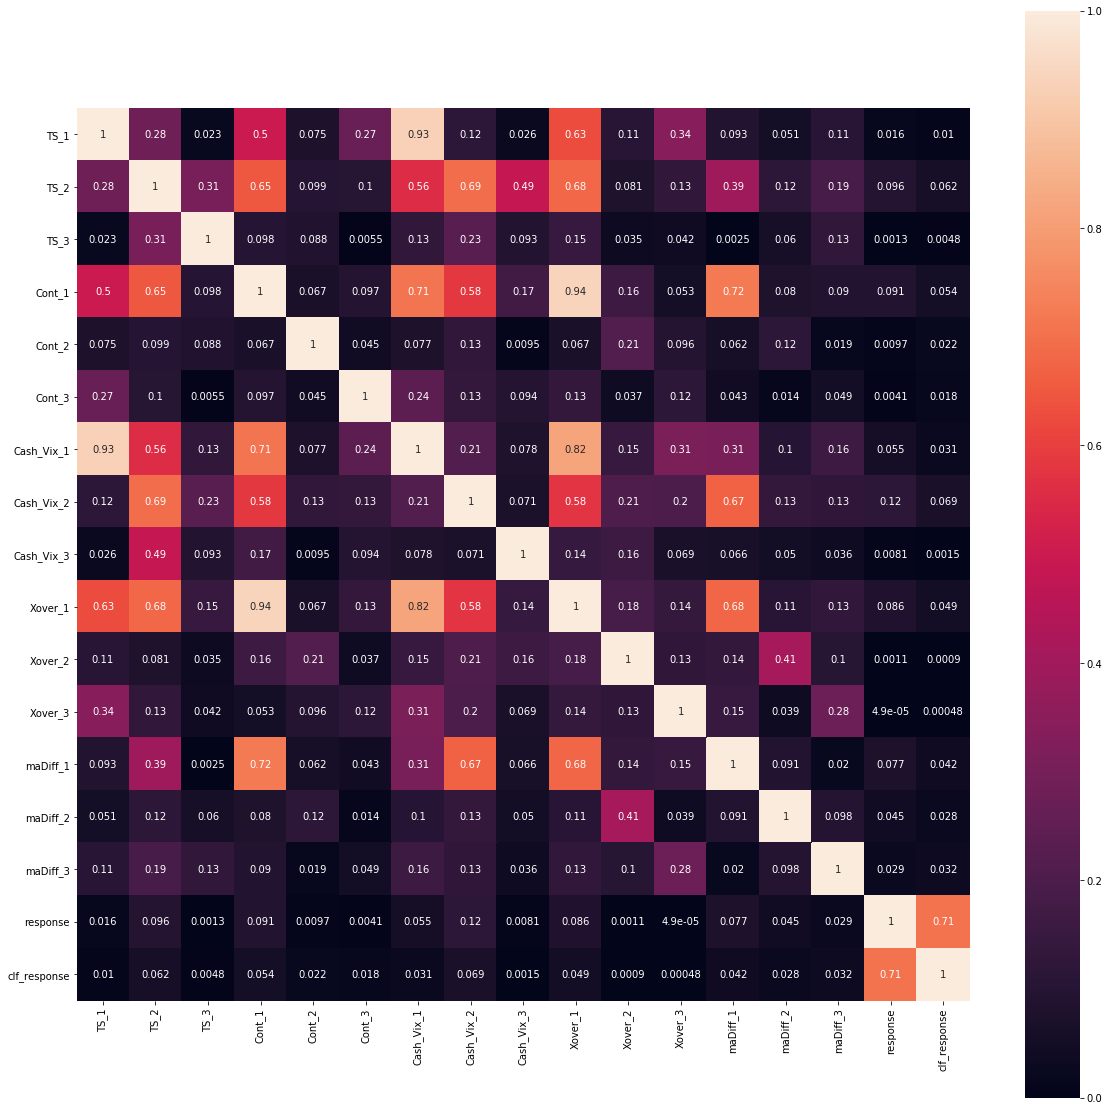

In [25]:
all_pcs_xts['response'] = variables['response']
all_pcs_xts['clf_response'] = variables['clf_response']
all_pcs_xts.head()
plt.figure(figsize=(20, 20))
sns.heatmap(np.abs(all_pcs_xts.corr()), square = True, annot = True)

# Visualize Features with Reasonable Correlation

Plot various features with absolute correlation at about .08 to see how they look like.
Looking for a usual normal state, with periods of stress distinct on the chart that are higher than normal conditions.
No third principal component had any correlation with the response variable at all.

C:\Users\Ilya\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


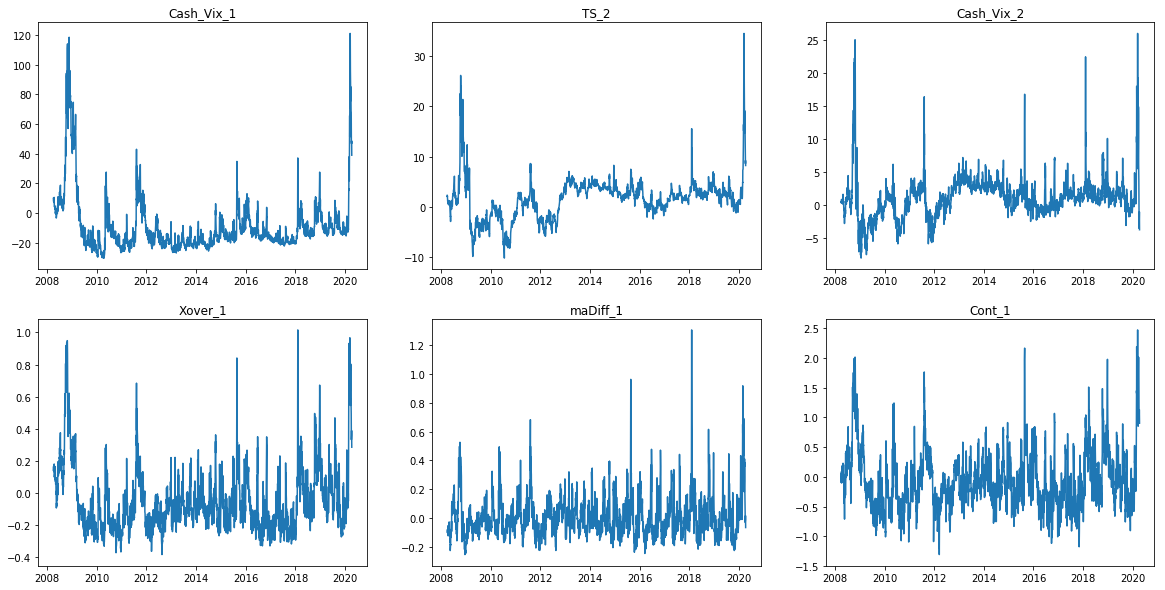

In [26]:
# plot some high correlation PCs -- the third PC in each group isn't correlated to response at all

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.plot(all_pcs_xts['Cash_Vix_1']) # yes
plt.title("Cash_Vix_1")

plt.subplot(2, 3, 2)
plt.plot(all_pcs_xts['TS_2']) # no
plt.title("TS_2")

plt.subplot(2, 3, 3)
plt.plot(all_pcs_xts['Cash_Vix_2']) # no
plt.title("Cash_Vix_2")

plt.subplot(2, 3, 4)
plt.plot(all_pcs_xts['Xover_1']) # yes
plt.title("Xover_1")

plt.subplot(2, 3, 5)
plt.plot(all_pcs_xts['maDiff_1']) # yes
plt.title("maDiff_1")

plt.subplot(2, 3, 6)
plt.plot(all_pcs_xts['Cont_1']) # no
plt.title("Cont_1")
plt.show()

# Let's try UMAP instead of PCA.

PCA goes for trying to explain the most variance with disparate points, while UMAP performs dimensionality reduction through trying to find the most similar points in a similar fashion to nearest neighbor. 

We'll use the same rolling algorithm as with PCAs.

In [27]:
import umap


def umap_xform(train, test, min_dist, n_neighbors, n_components, stem = "UMAP"):
  um = umap.UMAP(n_neighbors = n_neighbors, n_components = n_components, min_dist = min_dist, metric = 'correlation')
  um.fit(train)
  train_xform = pd.DataFrame(um.transform(train))
  test_xform = pd.DataFrame(um.transform(test))
  train_xform.columns = test_xform.columns = [stem + "_" + str(x) for x in np.array(range(1, n_components +1))]
  train_xform = train_xform.set_index(train.index)
  test_xform = test_xform.set_index(test.index)
  return [train_xform, test_xform]

    

In [28]:

def umap_features(variables, ep, min_dist = 0.00000001, n_neighbors = 20, n_components = 2):
    all_umap = []
    for i in range(0, (len(ep)-11)):
     print(i)

     # same logic as PCs
     if(i < len(ep)-12):
      training = variables.iloc[0:ep[i+11]]   
      testing = variables.iloc[(ep[i+11]+1):ep[i+12]]
     else:
      training = variables.iloc[(ep[11]+1):ep[len(ep)-1]]
      testing = variables.iloc[0:ep[11]]

     X_train = training.drop(['response', 'clf_response'], axis = 1)
     y_train = training['clf_response']

     X_test = testing.drop(['response', 'clf_response'], axis = 1)
     y_test = testing['clf_response']

     #print(X_train.tail())

     # THIS IS THE SECTION FOR PCAs AND FEATURE ENGINEERING

     # Term structure PCA
     ts_umap = umap_xform(X_train[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']],
                      X_test[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']],
                      min_dist = min_dist,
                      n_neighbors = n_neighbors,
                      n_components = n_components,
                      stem = "TS")

     # Contango metrics PCA
     contango_umap = umap_xform(X_train[['vxxCrush', 'm1_roll_yield', 'VX30_roll_yield', 'contango', 'adj_contango', 'm4m7_contango']],
                            X_test[['vxxCrush', 'm1_roll_yield', 'VX30_roll_yield', 'contango', 'adj_contango', 'm4m7_contango']],
                            min_dist = min_dist,
                            n_neighbors = n_neighbors,
                            n_components = n_components,
                            stem = "Cont")

     # Cash VIX PCA (correlated with contango)
     cash_vix_umap = umap_xform(X_train[['VIX9D',	'VIX',	'VIX3M',	'VIX6M']],
                            X_test[['VIX9D',	'VIX',	'VIX3M',	'VIX6M']],
                            min_dist = min_dist,
                            n_neighbors = n_neighbors,
                            n_components = n_components,
                            stem = "Cash_Vix")

     # Crossover/ratio PCAs (VIX/VIX3M, etc.)
     xover_umap = umap_xform(X_train[['fastcross', 'medcross', 'slowcross', 'stratcross']],
                         X_test[['fastcross', 'medcross', 'slowcross', 'stratcross']],
                         min_dist = min_dist,
                         n_neighbors = n_neighbors,
                         n_components = n_components,
                         stem = "Xover")

     # Difference to a moving average PCAs
     maDiff_umap = umap_xform(X_train[['fast_diff', 'med_diff', 'slow_diff', 'strat_diff']],
                         X_test[['fast_diff', 'med_diff', 'slow_diff', 'strat_diff']],
                         min_dist = min_dist,
                         n_neighbors = n_neighbors,
                         n_components = n_components,
                         stem = "maDiff")

     # create data frame of new features
     train_umap = pd.concat([ts_umap[0], contango_umap[0], cash_vix_umap[0], xover_umap[0], maDiff_umap[0]], axis = 1)
     test_umap = pd.concat([ts_umap[1], contango_umap[1], cash_vix_umap[1], xover_umap[1], maDiff_umap[1]], axis = 1)
     #test_pcs = test_pcs.dropna()

     #print(test_umap.tail())
     all_umap.append(test_umap)
    all_umap_xts = pd.concat(all_umap, axis=0)
    all_umap_xts = all_umap_xts.sort_index()
    return all_umap_xts
    

In [29]:
umap_vars = umap_features(variables, ep)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


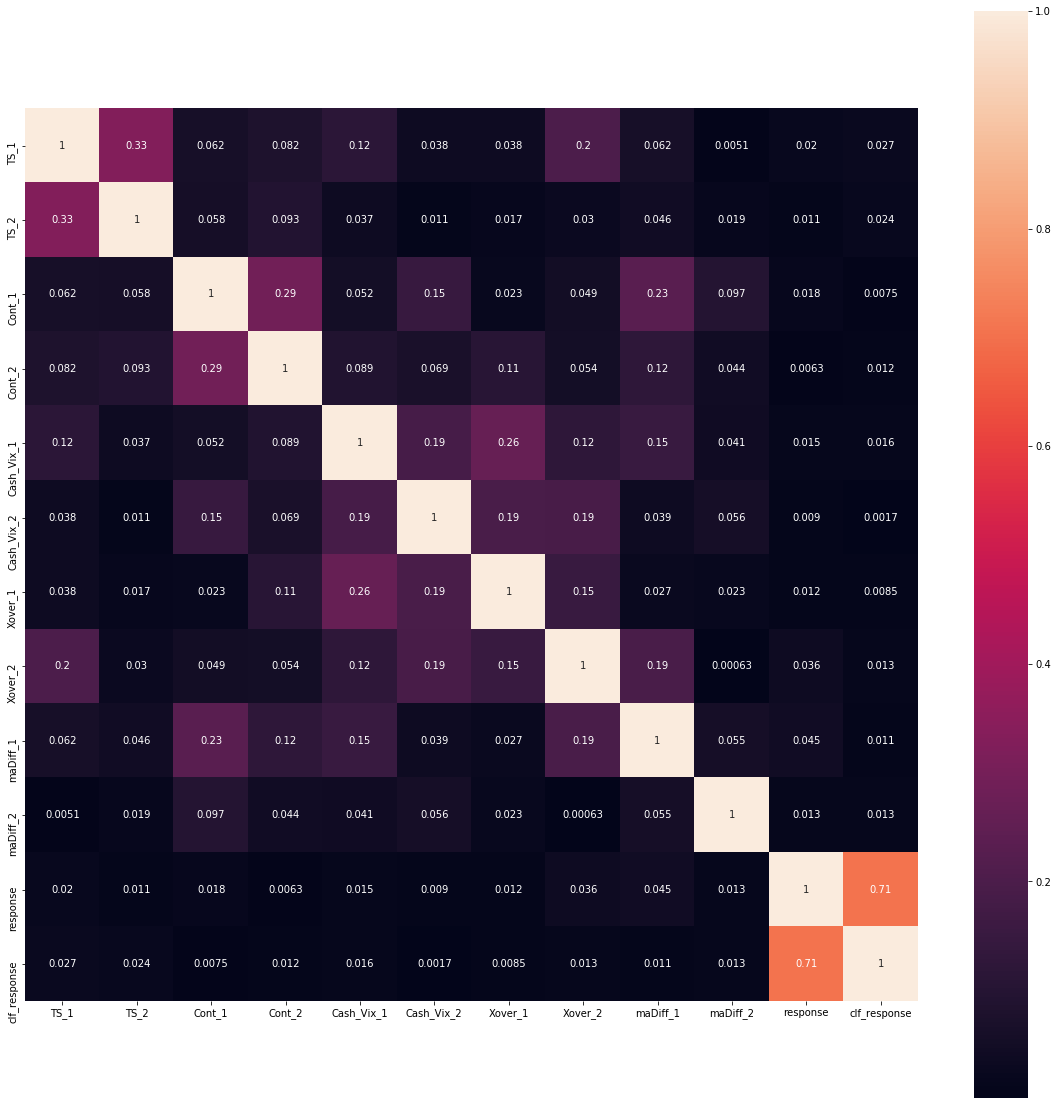

In [30]:


umap_vars['response'] = variables['response']
umap_vars['clf_response'] = variables['clf_response']
plt.figure(figsize=(20, 20))
sns.heatmap(np.abs(umap_vars.corr()), square = True, annot = True)

# Trial 1? Failure.

UMAP using 20 nearest neighbors with zero minimum distance finds only noise, without even the slightest hint of correlation in variables that PCA found some association with. The near-zero correlations mean that there is no relationship being picked up.

Trying higher minimum distance and more points.

In [31]:
umap_vars_2 = umap_features(variables, ep, min_dist = 0.5, n_neighbors = 50)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


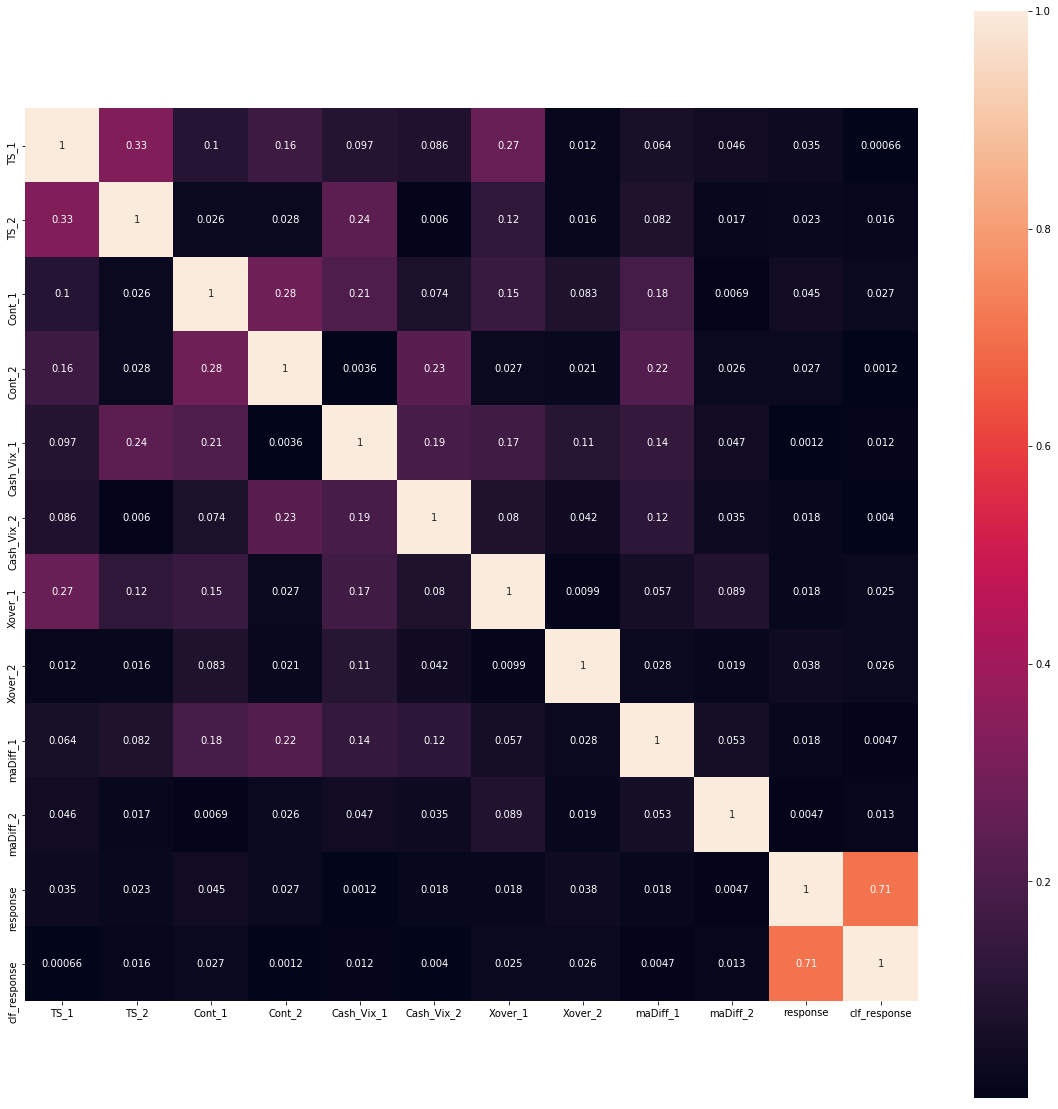

In [32]:


umap_vars_2['response'] = variables['response']
umap_vars_2['clf_response'] = variables['clf_response']
plt.figure(figsize=(20, 20))
sns.heatmap(np.abs(umap_vars_2.corr()), square = True, annot = True)

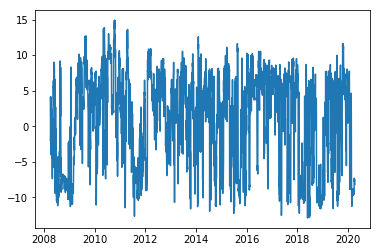

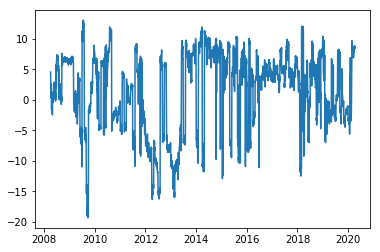

In [59]:
plt.plot(umap_vars_2['Cont_1'])
plt.show()
plt.plot(umap_vars_2['TS_1'])
plt.show()

# Higher Minimum Distance and Neighbors Also a Failure
# Create a Trading System from PCA Features

Two most highly correlated charts still look exceptionally noisy and not really worth trying to form a trading signal from.

Rolling UMAP is also far too computationally intensive to do any real parameter experimentation, and requires too much parameterization as well. 

It seems PCA is the better dimensionality reduction technique.

Next, we'll attempt to create a trading system from some of the PCA output's features. The rubric has been previously stated: variables that make crises visually distinct from normal behavior, with normal behavior values being lower than those of crises.

Base strategy rules: short vol when stratcross (aka VIX3M/VIX6M) < 1 and strat_diff (difference between the strat cross and its 60 day moving average) is < 0, and long vol when vice versa. Stay in cash otherwise.  

PCA strategy rules: short vol when the first PCA of cash vix is < 0, when the first PCA of the crossover ratios is less than 0, and when the first moving average difference PCA is less than zero. Long vol when vice versa. Cash otherwise.

In [34]:
variables.head()
base_strat = ((variables['stratcross'] < 1) & (variables['strat_diff'] < 0)) * variables['response'] + ((variables['stratcross'] > 1) & (variables['strat_diff'] > 0)) * -variables['response']
pca_strat = ((all_pcs_xts['Cash_Vix_1'] < 0) & (all_pcs_xts['Xover_1'] < 0) & (all_pcs_xts['maDiff_1'] < 0)) * all_pcs_xts['response'] + ((all_pcs_xts['Cash_Vix_1'] > 0) & (all_pcs_xts['Xover_1'] > 0) & (all_pcs_xts['maDiff_1'] > 0)) * -all_pcs_xts['response']


In [35]:
def annualized_returns(r, periodsInYear = 252):
    return ((1+r).prod()**(periodsInYear/r.shape[0])-1)

def annualized_vol(r, periodsInYear = 252):
    return r.std(ddof=0)*np.sqrt(periodsInYear)

def drawdown(return_series: pd.Series):
    """
    Computes wealth index, drawdowns/max DDs for a time series
    """
    wealth_idx = (1+return_series).cumprod()
    previous_peaks = wealth_idx.cummax()
    drawdown = (wealth_idx-previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_idx,
        "Peaks": previous_peaks,
        "Drawdown": drawdown
    })


Annualized returns of benchmark strategy: 
0.7857415925680278

Annualized returns of PCA strategy: 
0.5134312700334354

Annualized std. dev. of base strat: 
0.5019604180988085

Annualized std. dev. of pca strat: 
0.47852410198686723


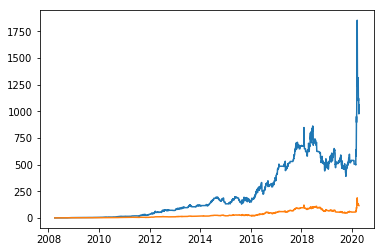

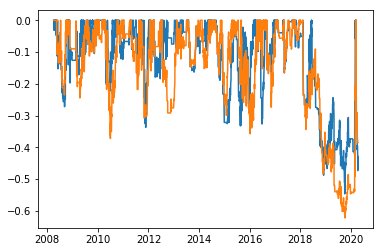


Max Drawdown returns of benchmark strategy: 
0.5465729710396717

Max Drawdown returns of PCA strategy: 
0.6222369287893654


In [55]:
print("\nAnnualized returns of benchmark strategy: \n" + str(annualized_returns(base_strat)))
print("\nAnnualized returns of PCA strategy: \n" + str(annualized_returns(pca_strat)))

print("\nAnnualized std. dev. of base strat: \n" + str(annualized_vol(base_strat)))
print("\nAnnualized std. dev. of pca strat: \n" + str(annualized_vol(pca_strat)))

base_wealth = drawdown(base_strat)['Wealth']
pca_wealth = drawdown(pca_strat)['Wealth']
plt.show()

plt.plot(base_wealth)
plt.plot(pca_wealth)
plt.show()
#plt.plot(base_wealth)
plt.plot(drawdown(base_strat)['Drawdown'])
plt.plot(drawdown(pca_strat)['Drawdown'])
plt.show()


print("\nMax Drawdown returns of benchmark strategy: \n" + str(min(drawdown(base_strat)['Drawdown'])*-1))
print("\nMax Drawdown returns of PCA strategy: \n" + str(min(drawdown(pca_strat)['Drawdown'])*-1))


#avg_strat = (base_strat + pca_strat)/2
#print(annualized_returns(avg_strat))
#print(annualized_vol(avg_strat))

#plt.plot(drawdown(avg_strat)['Wealth'])
#plt.show()


In [37]:
pca_strat.corr(base_strat)

0.8034969137549053

# Preliminary Conclusions

It would seem that all of the additional features actively make the strategy worse. The methodology for the trading system in both cases was relatively similar. One last idea is to check whether or not acknowledging this and seeing if this strategy consistently underperforms the base signal.

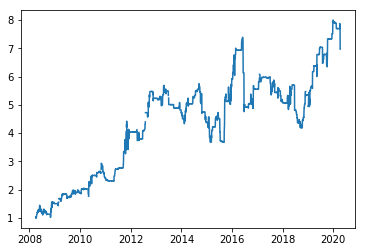

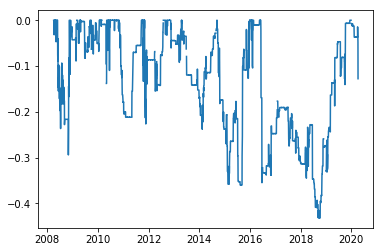


Annualized return:

0.17538402966994715

Annualized volatility:

0.30878920836817975

Maximum Drawdown:

0.4317118689582349

Correlation with base strategy:

0.38590712806206506


In [51]:
diff_strat = base_strat - pca_strat
plt.plot(drawdown(diff_strat)['Wealth'])
plt.show()

plt.plot(drawdown(diff_strat)['Drawdown'])
plt.show()

print("\nAnnualized return:\n")
print(annualized_returns(diff_strat))
print("\nAnnualized volatility:\n")
print(annualized_vol(diff_strat))
print("\nMaximum Drawdown:\n")
print(min(drawdown(diff_strat)['Drawdown'])*-1)

print("\nCorrelation with base strategy:\n")
print(base_strat.corr(diff_strat))

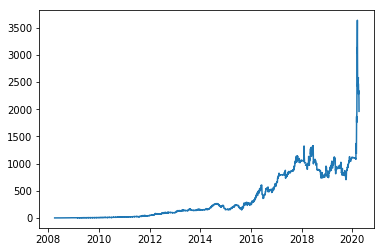

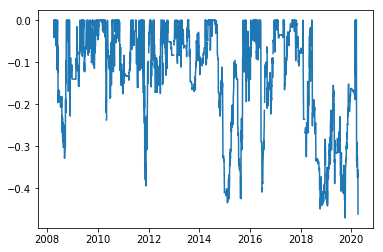


Annualized return:

0.8797277422808707

Annualized volatility:

0.5461338331955875

Maximum Drawdown:

0.47005265651414707


In [57]:
strat_13030 = base_strat + diff_strat * .3
plt.plot(drawdown(strat_13030)['Wealth'])
plt.show()
plt.plot(drawdown(strat_13030)['Drawdown'])
plt.show()

print("\nAnnualized return:\n")
print(annualized_returns(strat_13030))
print("\nAnnualized volatility:\n")
print(annualized_vol(strat_13030))
print("\nMaximum Drawdown:\n")
print(min(drawdown(strat_13030)['Drawdown'])*-1)

# Final Conclusions

Garbage features = garbage performance, to the point that the base signal outperforms the PCA signal *consistently*.

-The long-short strategy (long base signal, short pca signal) is actually not too correlated to the base signal, so can be added on top of it to form a 130-30 strategy.   
-This 130-30 strategy has larger drawdowns.   
-The performances presented in these projects do not implement the additional risk management features that I have found over the course of trading and building upon the base signal I published on my blog in late 2014.  

Original base strategy source post: https://quantstrattrader.wordpress.com/2014/12/10/an-update-to-the-robustness-heuristic-and-a-variation-of-a-volatility-strategy/

There may be more room for improving the long-short strategy going forward, but that's research for another day.

Thank you very much.